In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.interpolate import griddata


from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns


In [2]:
class GaussianMixtureModel:
    '''
     This class implements a Gaussian Mixture Model which has several methods for 
     data generation, likelihood calculation, and visualization of the results.
     
    '''
    def __init__(self, n_dimensions, n_components, means, covs, weights):
        '''
        Initializes the class with the number of dimensions, number of components, 
        means, covariance matrices, and weights for each dimension.
        
        Arguments
        n_dimensions [int]: number of dimensions of dataset
        n_components [int]: number of components in the input data
        means [list]: means for each Gaussian component
        covs [list]: covariance matrices for each Gaussian component
        weights [list]: weights for each Gaussian component
        
        '''
        self.n_dimensions = n_dimensions
        self.n_components = n_components
        self.means = means
        self.covs = covs
        self.weights = weights
        # initialize the noisy_data attribute to None
        self.noisy_data = None

    
    def generate_data(self, n_samples, noise_scale=0.1):
        # generate samples from the Gaussian mixture model
        X = np.zeros((n_samples, self.n_dimensions))
        c = np.random.choice(self.n_components, size=n_samples, p=self.weights)
        for i in range(self.n_components):
            idx = (c == i)
            X[idx, :] = np.random.multivariate_normal(mean=self.means[i], cov=self.covs[i], size=np.sum(idx))
        
        # add noise to the samples
        noise = np.random.normal(scale=noise_scale, size=X.shape)
        noisy_data = X + noise
        
        # store the noisy_data attribute
        self.noisy_data = noisy_data
        
        # return the samples and the noisy_data
        return X, noisy_data
    
    
    def plot_scatter(self, X):
        '''
        Plots scatter plot for data.
        
        Arguments
        X [np.array]: dataset for which scatter plot will be plotted
        
        Returns
        None
                
        '''
        plt.rcParams["figure.figsize"] = (8, 6)
        
        n_dimensions = X.shape[1]
        
        # 2D data
        if n_dimensions == 2:
            plt.scatter(X[:, 0], X[:, 1], marker = 'o', s = 6, alpha = 0.5)
            plt.title("Scatter plot for Gaussian Mixture Model")
            plt.xlabel("$\mu1$")
            plt.ylabel("$\mu2$")
            plt.savefig('2Dscatter')
            plt.show()
        
        # 3D data
        elif n_dimensions == 3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection = '3d')
            ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker = 'o', s = 6, alpha = 0.5)
            plt.title("Scatter plot for Gaussian Mixture Model")
            ax.set_xlabel("$\mu1$")
            ax.set_ylabel("$\mu2$")
            ax.set_zlabel("$\mu3$")
            plt.savefig('3Dscatter')
            plt.show()

    
    def plot_histograms(self, X, noise_scale=None):
        '''
        Plots histograms for data.

        Arguments
        X [np.array]: dataset for which histograms will be plotted
        noise_scale [float]: standard deviation of the Poisson noise added to the data, if any

        Returns
        None

        '''

        n_dimensions = X.shape[1]

        fig, axs = plt.subplots(n_dimensions, figsize=(6, 3*self.n_dimensions))

        for i in range(n_dimensions):
            if noise_scale is not None:
                noisy_data = np.random.normal(X[:, i], scale=noise_scale)
                noisy_counts, noisy_edges = np.histogram(noisy_data, bins=30)
                noisy_bin_centers = (noisy_edges[:-1] + noisy_edges[1:]) / 2.0
            else:
                noisy_counts, noisy_bin_centers = None, None

            data_counts, data_edges = np.histogram(X[:, i], bins=30)
            data_bin_centers = (data_edges[:-1] + data_edges[1:]) / 2.0

            axs[i].bar(data_bin_centers, data_counts, alpha=0.5, label='Data', width=(data_bin_centers[1] - data_bin_centers[0]))

            if noisy_data is not None:
                for j in range(len(data_counts)):
                    idx = np.abs(noisy_bin_centers - data_bin_centers[j]).argmin()
                    axs[i].scatter(data_bin_centers[j], noisy_counts[idx], color='red')

            axs[i].set_xlabel('mu{}'.format(i+1))
            axs[i].set_ylabel('Frequency')

            if noisy_data is not None:
                axs[i].legend(loc='upper right')

        fig.tight_layout()
        plt.show()


    def pdf(self, X):
        '''
        Calculates the probability density function (pdf) of the Gaussian Mixture Model 
        for a given set of samples in X.
    
    
            p(x_j|θ) is the probability density function at each independent sample with
            θ represents the parameters mean, covariance, and mixture coefficients,
            and x_1, x_2, ... , x_n are the observed samples in dataset X.
        
        
        Arguments
        X [np.array]: dataset for which pdf will be calculated

        Returns
        probs [np.array]: probabilities of the Gaussian Mixture Model for each sample in X
        
        '''
        prob = np.zeros((X.shape[0], self.n_components)) # initialize a numpy array of zeros to store probs of each sample

        for i in range(self.n_components):
            # calculate pdf of each component at each sample in X
            prob[:, i] = self.weights[i] * multivariate_normal.pdf(X, mean = self.means[i], cov = self.covs[i])
        probs = np.sum(prob, axis = 1) # sum probabilities of each component at each sample
        
        return probs

         
        
    def calculate_likelihoods(self, X):
        '''
        Calculates the likelihood of the Gaussian Mixture Model for a given set of samples in X.


            The likelihood is calculated as the product of individual pdfs at the observed samples:

            L(θ) = p(x_1, x_2, ..., x_N|θ) = Π_j=1^N p(x_j|θ)

            Since likelihood of each point may be very small, leading to extremely small products, 
            a log likelihood is often used in practice:

            logL(θ) = Σ_j=1^N log(p(x_j|θ)) 

        
        Arguments
        X [np.array]: dataset for which log-likelihoods will be calculated

        Returns
        log_likelihoods [np.array]: log-likelihood of each sample in dataset X
        
        '''

        log_likelihoods = np.zeros(X.shape[0]) # initialize a numpy array of zeros to store log-likelihoods of each sample
        
        for i, x in enumerate(X):
            log_likelihood = 0 
            for j in range(self.n_components):
                # calculate log-likelihood of each sample by
                # adding product of mixture coefficient and pdf at sample x_j for each Gaussian component k
                log_likelihood += self.weights[j] * multivariate_normal.pdf(x, mean = self.means[j], cov = self.covs[j])
            log_likelihoods[i] = np.log(log_likelihood) # store in log_likelihoods numpy array
        
        return log_likelihoods # return log-likelihood of each sample in dataset X


    def plot_likelihood(self, X, probs):
        '''
        Plots the likelihood surface of data.

        Arguments
        X [np.array]: dataset for which scatterplot will be plotted
        probs [np.array]: probabilities of the Gaussian Mixture Model for each sample in X
        
        Returns
        None

        '''
        if self.n_dimensions == 2:
            fig = plt.figure(figsize = (8, 8), facecolor = "white")
            ax = fig.add_subplot(projection = "3d")
            
            x = X[:, 0]
            y = X[:, 1]
            z = probs
            
            # interpolate the points to make the plot smoother
            xi = np.linspace(min(x), max(x), 500)
            yi = np.linspace(min(y), max(y), 500)
            X, Y = np.meshgrid(xi, yi)
            Z = griddata((x, y), z, (X, Y), method='cubic')

            # plot the wireframe
            ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
            
            # plot scatter plot
            ax.scatter(x, y, z, color = 'r',  marker = '.', alpha = 0.7)

            ax.set_xlabel("mu1")
            ax.set_ylabel("mu2")
            ax.set_zlabel("Likelihood")
            ax.set_title("Likelihood Plot")
            fig.tight_layout()
            plt.savefig('likelihood')
            fig.show()



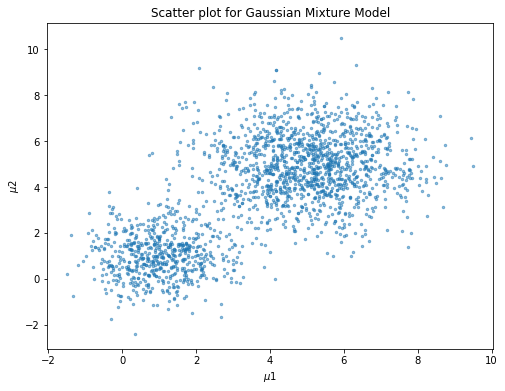

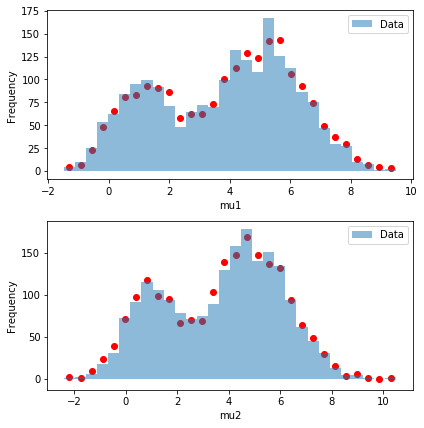

[0.00218156 0.04139327 0.01263663 ... 0.00100491 0.05126821 0.01805678]
[-6.12771516 -3.18463693 -4.37115518 ... -6.90285964 -2.97068441
 -4.01423401]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:233: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


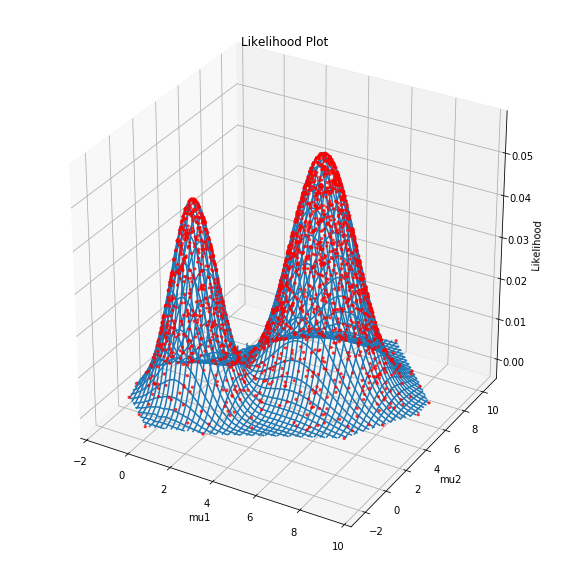

In [3]:
# Define the Gaussian Mixture Model with 2 dimensions and 2 components
dimensions = 2
components = 2

gmm1 = GaussianMixtureModel(n_dimensions = dimensions, 
                            n_components = components, 
                           means = [[1, 1], [5, 5]], 
                           covs = [[[1, 0], [0, 1]], 
                                 [[2, 0], [0, 2]]], 
                           weights = [0.3, 0.7])

# Initialize the Gaussian Mixture Model class with n samples
n_samples = 2000
noise = 0.2
X1, noisy_data1 = gmm1.generate_data(n_samples, noise_scale = noise)

# Plot the data X
gmm1.plot_scatter(X1)

# Plot the histograms of data X
gmm1.plot_histograms(X1,noise_scale=noise)

# Calculate pdf of the data X 
prob1 = gmm1.pdf(X1)
print(prob1)

# Calculate log-likelihoods of data X
log_likelihood1 = gmm1.calculate_likelihoods(X1)
print(log_likelihood1)

# Plot the likelihoods of data X
gmm1.plot_likelihood(X1, prob1)


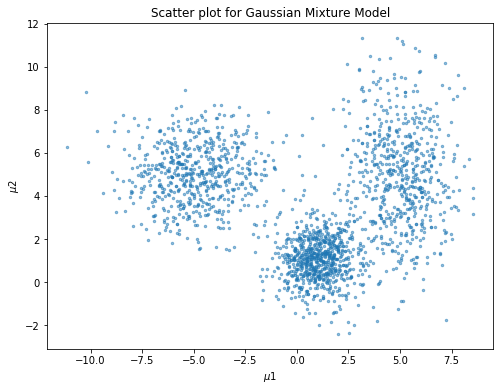

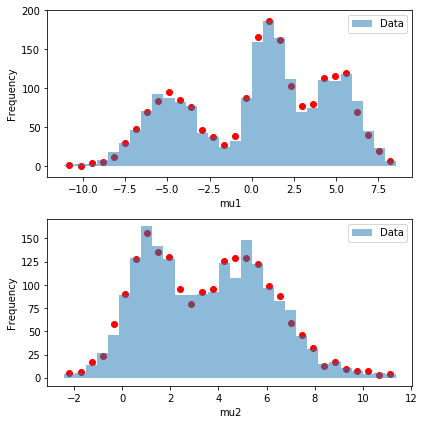

[0.05723119 0.01099861 0.01556781 ... 0.00412957 0.06369412 0.0241937 ]
[-2.8606563  -4.50998596 -4.16254988 ... -5.48958261 -2.753663
 -3.72166311]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:233: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


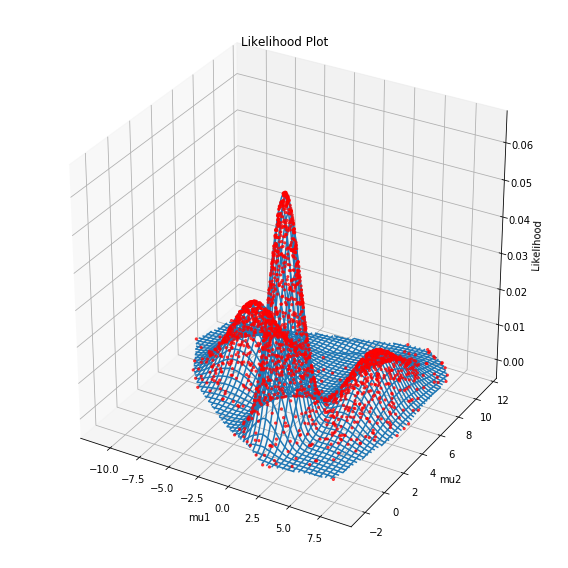

In [4]:
# Define the Gaussian Mixture Model with 2 dimensions and 3 components
dimensions = 2
components = 3

gmm2 = GaussianMixtureModel(n_dimensions = dimensions, 
                            n_components = components, 
                           means = [[1, 1], [-5, 5], [5, 5]], 
                           covs = [[[1, 0], [0, 1]], 
                                   [[3, 0], [0, 2]],
                                   [[2, 0], [0, 5]]],
                           weights = [0.4, 0.3, 0.3])


# Initialize the Gaussian Mixture Model class with n samples
n_samples = 2000
noise = 0.2
X2, noisy_data2 = gmm2.generate_data(n_samples, noise_scale = noise)


# Plot the data X
gmm2.plot_scatter(X2)


# Plot the histograms of data X
gmm2.plot_histograms(X2, noise_scale=noise)


# Calculate pdf of the data X 
prob2 = gmm2.pdf(X2)
print(prob2)


# Calculate log-likelihoods of data X
log_likelihood2 = gmm2.calculate_likelihoods(X2)
print(log_likelihood2)

# Plot the likelihoods of data X
gmm2.plot_likelihood(X2, prob2)

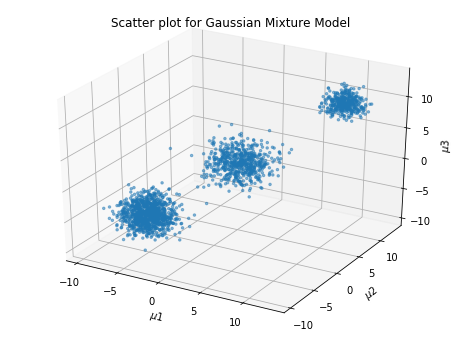

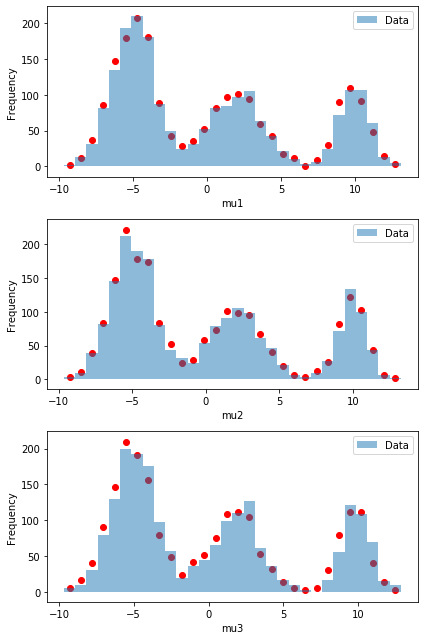

[0.00104639 0.0017449  0.00091979 ... 0.00672407 0.00292276 0.00424844]
[-6.86240808 -6.35105964 -6.99136028 ... -5.00206163 -5.83522796
 -5.46120386]


In [5]:
# Define the Gaussian Mixture Model with 3 dimensions and 3 components
dimensions = 3
components = 3

gmm3 = GaussianMixtureModel(n_dimensions = dimensions, 
                           n_components = dimensions, 
                           means = [[10, 10, 10], [-5, -5, -5], [2, 2, 2]], 
                           covs = [[[1, 0, 0], [0, 1, 0], [0, 0, 1]], 
                                   [[2, 0, 0], [0, 2, 0], [0, 0, 2]],
                                   [[3, 0, 0], [0, 3, 0], [0, 0, 3]]], 
                           weights=[0.2, 0.5, 0.3])


# Initialize the Gaussian Mixture Model class with n samples
n_samples = 2000
noise = 0.2
X3, noisy_data3 = gmm3.generate_data(n_samples, noise_scale = noise)


# Plot the data X
gmm3.plot_scatter(X3)


# Plot the histograms of data X
gmm3.plot_histograms(X3, noise_scale=noise)


prob3 = gmm3.pdf(X3)
print(prob3)


# Calculate the likelihood of the data X
log_likelihood3 = gmm3.calculate_likelihoods(X3)
print(log_likelihood3)


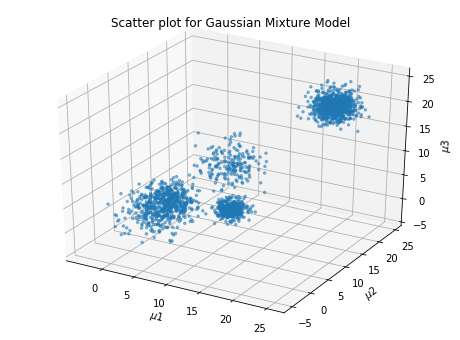

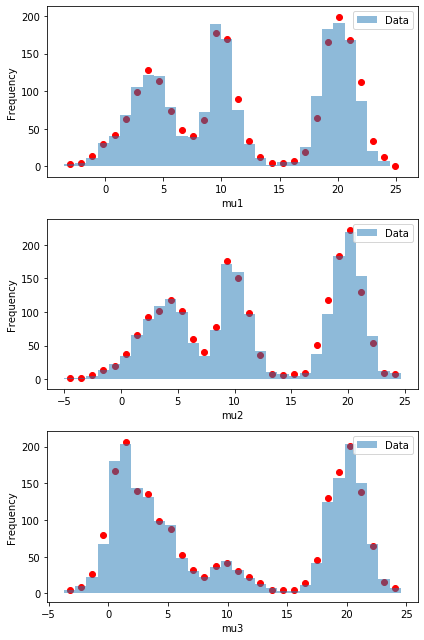

[0.00320446 0.00160015 0.0053136  ... 0.00213052 0.00528101 0.00014719]
[-5.74321132 -6.43766088 -5.23748659 ... -6.15139017 -5.24363855
 -8.82381214]


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian Mixture Model with 3 dimensions and 5 components
dimensions = 3
components = 5

gmm4 = GaussianMixtureModel(n_dimensions = dimensions, 
                           n_components = components, 
                            means = [[10, 10, 1], [2, 2, 2], [20, 20, 20], [4, 4, 4], [10, 10, 10]],
                            covs = [[[1, 0, 0], [0, 1, 0], [0, 0, 1]], 
                                    [[5, 0, 0], [0, 5, 0], [0, 0, 5]],
                                    [[2, 0, 0], [0, 2, 0], [0, 0, 2]],
                                    [[3, 0, 0], [0, 3, 0], [0, 0, 3]],
                                    [[5, 0, 0], [0, 5, 0], [0, 0, 5]]],
                            weights = [0.2, 0.1, 0.4, 0.2, 0.1])
                    
    
# Initialize the Gaussian Mixture Model class with n samples
n_samples = 2000
noise = 0.2
X4, noisy_data4 = gmm4.generate_data(n_samples, noise_scale = noise)


# Plot the data X
gmm4.plot_scatter(X4)


# Plot the histograms of data X
gmm4.plot_histograms(X4, noise_scale=noise)


# Calculate pdf of the data X 
prob4 = gmm4.pdf(X4)
print(prob4)


# Calculate log-likelihoods of data X
log_likelihood4 = gmm4.calculate_likelihoods(X4)
print(log_likelihood4)

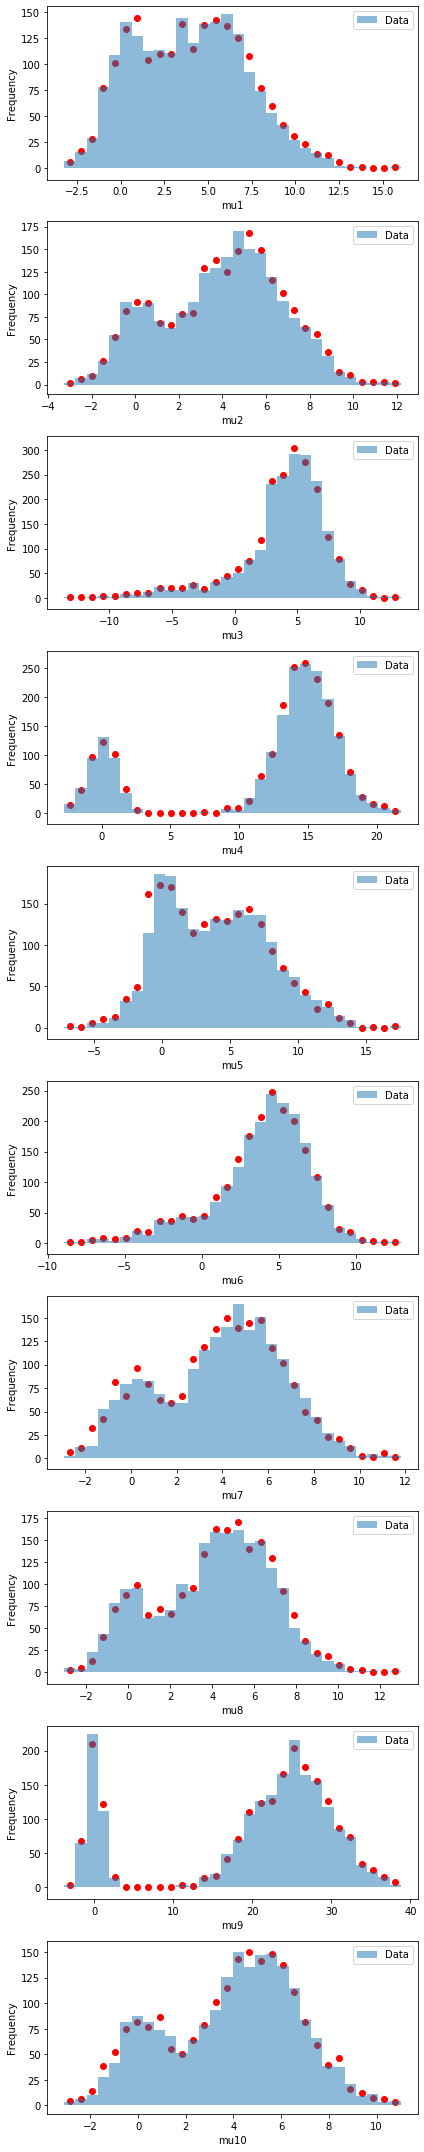

[2.91983558e-10 5.24260785e-11 1.49434403e-12 ... 2.30868035e-10
 5.08501104e-11 3.58857971e-10]
[-21.95432362 -23.67161697 -27.22933378 ... -22.18917485 -23.70213882
 -21.74809443]


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian Mixture Model with 10 dimensions and 2 components
dimensions = 10
components = 2


gmm5 = GaussianMixtureModel(n_dimensions = dimensions, 
                           n_components = components, 
                            means = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                     [5, 5, 5, 15, 5, 5, 5, 5, 25, 5]],
                            covs = [[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 
                                     [0, 0, 21, 0, 0, 0, 0, 0, 0, 0], 
                                     [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 
                                     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 
                                     [0, 0, 0, 0, 0, 10, 0, 0, 0, 0], 
                                     [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 
                                     [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 
                                     [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 
                                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], 
                                    [[8, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                     [0, 4, 0, 0, 0, 0, 0, 0, 0, 0], 
                                     [0, 0, 4, 0, 0, 0, 0, 0, 0, 0], 
                                     [0, 0, 0, 4, 0, 0, 0, 0, 0, 0], 
                                     [0, 0, 0, 0, 14, 0, 0, 0, 0, 0], 
                                     [0, 0, 0, 0, 0, 4, 0, 0, 0, 0], 
                                     [0, 0, 0, 0, 0, 0, 4, 0, 0, 0], 
                                     [0, 0, 0, 0, 0, 0, 0, 4, 0, 0], 
                                     [0, 0, 0, 0, 0, 0, 0, 0, 24, 0], 
                                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 4]]],
                            weights = [0.2, 0.8])
            
    
# Initialize the Gaussian Mixture Model class with n samples
n_samples = 2000
noise = 0.2
X5, noisy_data5 = gmm5.generate_data(n_samples, noise_scale = noise)


# Plot the data X
gmm5.plot_scatter(X5)


# Plot the histograms of data X
gmm5.plot_histograms(X5, noise_scale=noise)


# Calculate pdf of the data X 
prob5 = gmm5.pdf(X5)
print(prob5)


# Calculate log-likelihoods of data X
log_likelihood5 = gmm5.calculate_likelihoods(X5)
print(log_likelihood5)
